In [174]:
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import READ_EDAB_Utilities_py as reupy
from scipy.interpolate import RegularGridInterpolator
import os
import rdata

In [ ]:
#url = 'http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/northwest_atlantic/forecast/tob_forecast_i199303.nc'
#forecast_test = xr.open_dataset(url)

In [2]:
glbt = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/bt_glorys_M.nc')

In [3]:
mom6bt = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/ocean_monthly.199301-201912.tob.nc')

In [4]:
static = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/ocean_static_deptho.nc')

In [ ]:
gl_regrid = np.empty([342, 774, 844])
#gl_lons = np.concatenate((np.array(bt_glorys.longitude[:2161]+360), np.array(bt_glorys.longitude[2161:])))
LAT, LON = np.meshgrid(mom6bt.lat.values, mom6bt.lon.values-360)
for i in range(342):
    interp_to_mom6 = RegularGridInterpolator((glbt.latitude.values, glbt.longitude.values), glbt.bottomT[i,:,:].values, bounds_error = False, fill_value = np.nan)
    gl_regrid[i,:,:] = interp_to_mom6((LAT, LON))


In [ ]:
bt_gl = xr.Dataset(data_vars = {'tob': (['time','lon','lat'], gl_regrid)},
                          coords = {'time': glbt.time,
                                    'lat': mom6bt.lat,
                                    'lon': mom6bt.lon})

In [32]:
#subset to the SNE+MAB
# Load in the shapefile
epu = gpd.read_file('EPU_shape/EPU_NOESTUARIES.shp')
mab = epu[epu.EPU == 'MAB']
mab_m6 = reupy.crop_nd(mom6bt, 'lon', 'lat', mab)
mab_gl = reupy.crop_nd(bt_gl, 'lon', 'lat', mab)

In [33]:
epu

,FID_MAB_fu,ID,GRIDCODE,FID_GoM_fu,ID_1,GRIDCODE_1,FID_SS_ful,ID_12,GRIDCODE_2,FID_GB_ful,ID_12_13,GRIDCODE_3,EPU,Shape_Leng,Shape_Area,geometry
0,0,4.0,4.0,-1,0.0,0.0,-1,0.0,0.0,-1,0.0,0.0,MAB,2.352719e+06,8.813609e+10,"POLYGON ((-70.50000 41.16667, -70.50000 41.000..."
1,-1,0.0,0.0,0,2.0,7.0,-1,0.0,0.0,-1,0.0,0.0,GOM,1.240777e+06,5.393245e+10,"POLYGON ((-67.50000 42.00000, -68.00000 42.000..."
2,-1,0.0,0.0,-1,0.0,0.0,0,1.0,6.0,-1,0.0,0.0,SS,1.169825e+06,2.549858e+10,"POLYGON ((-66.00000 41.66667, -66.00000 41.833..."
3,-1,0.0,0.0,-1,0.0,0.0,-1,0.0,0.0,0,3.0,5.0,GB,1.231414e+06,4.914739e+10,"POLYGON ((-66.00000 41.66667, -66.00000 41.333..."


In [ ]:
#remove everything,200m
mab_m6_200 = mab_m6.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
mab_gl_200 = mab_gl.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))

In [98]:
mab_m6_200 = mab_m6.where(static.deptho < 200)
mab_m6_200

<xarray.Dataset>
Dimensions:  (time: 324, lat: 844, lon: 774)
Coordinates:
  * lon      (lon) float64 261.6 261.6 261.7 261.8 ... 323.7 323.8 323.8 323.9
  * lat      (lat) float64 5.273 5.335 5.398 5.461 ... 57.97 58.04 58.1 58.16
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2019-12-16T12:00:00
Data variables:
    tob      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    NumFilesInSet:       1
    title:               NWA12_COBALT_2023_04_kpo4-coastatten-physics
    associated_files:    areacello: 19930101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello
    history:             Derived and written at NOAA Physical Science Laboratory
    NCO:                 netCDF Operators version 5.0.1 (Homepage = http://nc...
    contact:             chia-wei.hsu@noaa.gov
    dataset:             regional mom6 regrid

In [ ]:
#remove everything except june-sept
def is_jjas(month):
    return (month >= 6) & (month <= 9)

mab_m6_200_jjas = mab_m6_200.sel(time=is_jjas(mab_m6_200['time.month']))
mab_gl_200_jjas = mab_gl_200.sel(time=is_jjas(mab_gl_200['time.month']))

In [ ]:
#calculate june-sept climatetological temp at each gridcell
clim_m6 = mab_m6_200_jjas.mean('time')
clim_gl = mab_gl_200_jjas.mean('time')

In [ ]:
# remove everything that is greater than 10C

clim_10_m6 = clim_m6.where(clim_m6.tob <=10)
clim_10_gl = clim_gl.where(clim_gl.tob <=10)

mab_m6_200_jjas_10 = mab_m6_200_jjas.where(clim_m6.tob <=10)
mab_gl_200_jjas_10 = mab_gl_200_jjas.where(clim_gl.tob <= 10)

$$ Model\, CPI_y =\frac{ \sum_{i=1}^{n} {(T_{i,y} - \bar{T}_{i,\, 1972-2019})}} {n} $$



In [ ]:
# Here we just use the time domain of the model 1993-2019 for Tbar

top_of_fraction_test = mab_m6_200_jjas_10.groupby('time.year').mean('time') - clim_10_m6

In [ ]:
plt.imshow(top_of_fraction_test.tob[10,:,:])
plt.colorbar()

In [ ]:
M_CPIy_m6 = (mab_m6_200_jjas_10.groupby('time.year').mean('time') - clim_10_m6).sum(['lat','lon'])/len(np.where(np.isnan(clim_10_m6.tob) == False)[0])

M_CPIy_gl = (mab_gl_200_jjas_10.groupby('time.year').mean('time') - clim_10_gl).sum(['lat','lon'])/len(np.where(np.isnan(clim_10_gl.tob) == False)[0])


In [ ]:
plt.plot(M_CPIy_m6.year, M_CPIy_m6.tob*-1, label = 'mom6')
plt.plot(M_CPIy_gl.year, M_CPIy_gl.tob*-1, label = 'glorys12')
plt.title('Model CPIy', fontsize = 12)
plt.legend()

$$ Model\, PI_y =\frac{ \sum_{i=1}^{n} {(Month_{i,y} - \bar{Month}_{i,\, 1972-2019})}} {n} $$


In [ ]:
mab_m6_200_10 = mab_m6_200.where(clim_m6.tob <=10)
def is_jjaso(month):
    return (month >= 6) & (month <= 10)

mab_m6_200_10_jjaso = mab_m6_200_10.sel(time=is_jjaso(mab_m6_200_10['time.month']))

# if the temperature never gets below 10C in one year that can be nan

years = np.arange(1993,2020)
day_yr = np.empty([len(years),144,124])
day_yr[:,:,:] = np.nan
j=0
for yr in years:
    year_subset = mab_m6_200_10_jjaso.sel(time= mab_m6_200_10_jjaso['time.year'] == yr)
    yr_mo = np.empty([144,124])
    yr_mo[:,:] = np.nan
    for k in np.arange(4,-1,-1):
        yr_mo[np.where(year_subset.tob[k,:,:] > 10)] = k+6
    day_yr[j,:,:] = yr_mo
    j = j+1

years = np.arange(1993,2021)
day_yr_gl = np.empty([len(years),144,124])
day_yr_gl[:,:,:] = np.nan
j=0
for yr in years:
    year_subset_gl = mab_gl_200_10_jjaso.sel(time= mab_gl_200_10_jjaso['time.year'] == yr)
    yr_mo_gl = np.empty([144,124])
    yr_mo_gl[:,:] = np.nan
    for k in np.arange(4,-1,-1):
        yr_mo_gl[np.where(year_subset_gl.tob[k,:,:] > 10)] = k+6
    day_yr_gl[j,:,:] = yr_mo_gl
    j = j+1

clim_day = np.nanmean(day_yr, 0)

day_yr_ds = xr.Dataset(data_vars={'month': (['year', 'lat','lon'], day_yr)},
           coords = {'year': np.arange(1993,2020),
                     'lat': mab_m6_200_10_jjaso.lat,
                     'lon': mab_m6_200_10_jjaso.lon})

day_yr_clim = xr.Dataset(data_vars = {'month': (['lat','lon'], clim_day)},
                         coords = {'lat': mab_m6_200_10_jjaso.lat,
                                   'lon': mab_m6_200_10_jjaso.lon})
model_piy_m6 = ((day_yr_ds - day_yr_clim).sum(['lat','lon']))/len(np.where(np.isnan(day_yr_clim.month) == False)[0])

In [ ]:
mab_m6_200_10 = mab_m6_200.where(clim_m6.tob <=10)
mab_gl_200_10 = mab_gl_200.where(clim_m6.tob <=10)

In [ ]:
def is_jjaso(month):
    return (month >= 6) & (month <= 10)

mab_m6_200_10_jjaso = mab_m6_200_10.sel(time=is_jjaso(mab_m6_200_10['time.month']))
mab_gl_200_10_jjaso = mab_gl_200_10.sel(time=is_jjaso(mab_gl_200_10['time.month']))

In [ ]:
# if the temperature never gets below 10C in one year that can be nan

years = np.arange(1993,2020)
day_yr = np.empty([len(years),144,124])
day_yr[:,:,:] = np.nan
j=0
for yr in years:
    year_subset = mab_m6_200_10_jjaso.sel(time= mab_m6_200_10_jjaso['time.year'] == yr)
    yr_mo = np.empty([144,124])
    yr_mo[:,:] = np.nan
    for k in np.arange(4,-1,-1):
        yr_mo[np.where(year_subset.tob[k,:,:] > 10)] = k+6
    day_yr[j,:,:] = yr_mo
    j = j+1

years = np.arange(1993,2021)
day_yr_gl = np.empty([len(years),144,124])
day_yr_gl[:,:,:] = np.nan
j=0
for yr in years:
    year_subset_gl = mab_gl_200_10_jjaso.sel(time= mab_gl_200_10_jjaso['time.year'] == yr)
    yr_mo_gl = np.empty([144,124])
    yr_mo_gl[:,:] = np.nan
    for k in np.arange(4,-1,-1):
        yr_mo_gl[np.where(year_subset_gl.tob[k,:,:] > 10)] = k+6
    day_yr_gl[j,:,:] = yr_mo_gl
    j = j+1

In [ ]:
clim_day = np.nanmean(day_yr, 0)

clim_day_gl = np.nanmean(day_yr_gl, 0)

In [ ]:
day_yr_ds = xr.Dataset(data_vars={'month': (['year', 'lat','lon'], day_yr)},
           coords = {'year': np.arange(1993,2020),
                     'lat': mab_m6_200_10_jjaso.lat,
                     'lon': mab_m6_200_10_jjaso.lon})

In [ ]:
day_yr_gl_ds = xr.Dataset(data_vars={'month': (['year', 'lat','lon'], day_yr_gl)},
           coords = {'year': np.arange(1993,2021),
                     'lat': mab_gl_200_10_jjaso.lat,
                     'lon': mab_gl_200_10_jjaso.lon})

In [ ]:
day_yr_clim = xr.Dataset(data_vars = {'month': (['lat','lon'], clim_day)},
                         coords = {'lat': mab_m6_200_10_jjaso.lat,
                                   'lon': mab_m6_200_10_jjaso.lon})

In [ ]:
day_yr_gl_clim = xr.Dataset(data_vars = {'month': (['lat','lon'], clim_day_gl)},
                         coords = {'lat': mab_gl_200_10_jjaso.lat,
                                   'lon': mab_gl_200_10_jjaso.lon})

In [ ]:
model_piy_m6 = ((day_yr_ds - day_yr_clim).sum(['lat','lon']))/len(np.where(np.isnan(day_yr_clim.month) == False)[0])

In [ ]:
model_piy_gl = ((day_yr_gl_ds - day_yr_gl_clim).sum(['lat','lon']))/len(np.where(np.isnan(day_yr_gl_clim.month) == False)[0])

In [ ]:
plt.plot(model_piy_m6.year, model_piy_m6.month, label = 'mom6')
plt.plot(model_piy_gl.year, model_piy_gl.month, label = 'glorys')
plt.title('Model PIy', fontsize = 12)
plt.legend()

$$ Model\, SEI = n\ cells <10C\ for\ 2\ months\ + $$

In [ ]:
mab_m6_200_jjas_10

In [ ]:
plt.imshow(mab_m6_200_jjas_10.tob[:4,:,:].where(mab_m6_200_jjas_10.tob[:4,:,:]<10)[0,:,:])
plt.colorbar()


In [ ]:
test_size_index = mab_m6_200_jjas_10.tob[:4,:,:].data

In [ ]:
test_size_index[np.where(test_size_index<10)] = 1
test_size_index[np.where(test_size_index>=10)] = 0

In [ ]:
test_diff = np.diff(test_size_index, axis =0)

In [ ]:
plt.imshow(test_diff[2,:,:])
plt.colorbar()

In [ ]:
len(np.where(test_diff == 0)[1])

In [ ]:
plt.plot(np.diff(np.where(test_diff == 0)[1]))

In [ ]:
len(np.where(np.diff(np.where(test_diff == 0)[1])!=0)[0])

In [ ]:
years = np.arange(1993,2020)

sei_m6 = [0]
for yr in years:
    year_subset_m6 = mab_m6_200_jjas_10.tob.sel(time= mab_m6_200_jjas_10['time.year'] == yr).data
    year_subset_m6[np.where(year_subset_m6<10)] = 1
    year_subset_m6[np.where(year_subset_m6>=10)] = 0
    year_subset_diff_m6 = np.diff(year_subset_m6, axis =0)
    sei_n_m6 = len(np.where(np.diff(np.where(year_subset_diff_m6 == 0)[1])!=0)[0])
    sei_m6 = np.append(sei_m6,sei_n_m6)
sei_m6=sei_m6[1:]

In [ ]:
years = np.arange(1993,2021)

sei_gl = [0]
for yr in years:
    year_subset_gl = mab_gl_200_jjas_10.tob.sel(time= mab_gl_200_jjas_10['time.year'] == yr).data
    year_subset_gl[np.where(year_subset_gl<10)] = 1
    year_subset_gl[np.where(year_subset_gl>=10)] = 0
    year_subset_diff_gl = np.diff(year_subset_gl, axis =0)
    sei_n_gl = len(np.where(np.diff(np.where(year_subset_diff_gl == 0)[1])!=0)[0])
    sei_gl = np.append(sei_gl,sei_n_gl)
sei_gl=sei_gl[1:]

In [ ]:
plt.plot(np.arange(1993,2020), sei_m6)
plt.plot(np.arange(1993,2021), sei_gl)

In [ ]:
plt.contourf(mab_m6_200_jjas_10.lon, mab_m6_200_jjas_10.lat, mab_m6_200_jjas_10.tob[0,:,:], levels = [)

In [ ]:
plt.contour(mab_m6_200.lon, mab_m6_200.lat, mab_m6_200.tob[5+36,:,:], levels = [10],colors = 'orange')
plt.contour(mab_gl_200.lon, mab_gl_200.lat, mab_gl_200.tob[5+36,:,:].T, levels = [10])

In [ ]:
years = np.arange(1993,2020)
row_num = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4]
col_num = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]
fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

In [ ]:

fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i+5]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

In [ ]:
fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i+10]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

In [ ]:
fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i+15]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

In [ ]:
fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i+20]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

In [ ]:
fig,ax = plt.subplots(nrows = 2, ncols = 5, figsize = [10,4], sharex = True, sharey = True)

for i in range(2):
    yr= years[i+25]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

# Forecasted Cold Pool
March and June initializations for JJAS of 2015, 2016, 2017, 2018, 2019

In [ ]:
tob_march_2015 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/March_init/tob_forecast_i201503.nc')
tob_march_2016 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/March_init/tob_forecast_i201603.nc')
tob_march_2017 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/March_init/tob_forecast_i201703.nc')
tob_march_2018 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/March_init/tob_forecast_i201803.nc')
tob_march_2019 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/March_init/tob_forecast_i201903.nc')

tob_june_2015 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/June_init/tob_forecast_i201506.nc')
tob_june_2016 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/June_init/tob_forecast_i201606.nc')
tob_june_2017 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/June_init/tob_forecast_i201706.nc')
tob_june_2018 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/June_init/tob_forecast_i201806.nc')
tob_june_2019 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/tob_forecast/June_init/tob_forecast_i201906.nc')

In [ ]:
tob_march_2015_mab = reupy.crop_nd(tob_march_2015, 'lon','lat',mab)
tob_march_2016_mab = reupy.crop_nd(tob_march_2016, 'lon','lat',mab)
tob_march_2017_mab = reupy.crop_nd(tob_march_2017, 'lon','lat',mab)
tob_march_2018_mab = reupy.crop_nd(tob_march_2018, 'lon','lat',mab)
tob_march_2019_mab = reupy.crop_nd(tob_march_2019, 'lon','lat',mab)

tob_june_2015_mab = reupy.crop_nd(tob_june_2015, 'lon','lat',mab)
tob_june_2016_mab = reupy.crop_nd(tob_june_2016, 'lon','lat',mab)
tob_june_2017_mab = reupy.crop_nd(tob_june_2017, 'lon','lat',mab)
tob_june_2018_mab = reupy.crop_nd(tob_june_2018, 'lon','lat',mab)
tob_june_2019_mab = reupy.crop_nd(tob_june_2019, 'lon','lat',mab)

In [ ]:
#remove everything,200m
tob_march_2015_mab_200 = tob_march_2015_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_march_2016_mab_200 = tob_march_2016_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_march_2017_mab_200 = tob_march_2017_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_march_2018_mab_200 = tob_march_2018_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_march_2019_mab_200 = tob_march_2019_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))

tob_june_2015_mab_200 = tob_june_2015_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_june_2016_mab_200 = tob_june_2016_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_june_2017_mab_200 = tob_june_2017_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_june_2018_mab_200 = tob_june_2018_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
tob_june_2019_mab_200 = tob_june_2019_mab.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))


In [ ]:
tob_march_2015_mab_200.tob.mean('member').sel(lead = slice(0,0))

In [ ]:
plt.contour(tob_march_2015_mab_200.lon, tob_march_2015_mab_200.lat, np.squeeze(tob_march_2015_mab_200.tob.mean('member').sel(lead = slice(5,5))), levels = [10])
for i in tob_march_2015_mab_200.member:
    plt.contour(tob_march_2015_mab_200.lon, tob_march_2015_mab_200.lat ,np.squeeze(tob_march_2015_mab_200.tob.sel(member = slice(i,i), lead = slice(5,5))), levels = [10], linewidths = 1, colors = 'grey', zorder = 0)
plt.contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice('2015-06-01', '2015-06-01')).tob).T, colors = 'red',levels = [10])

In [ ]:
plt.contour(tob_june_2015_mab_200.lon, tob_june_2015_mab_200.lat, np.squeeze(tob_june_2015_mab_200.tob.mean('member').sel(lead = slice(2,2))), levels = [10])
for i in tob_june_2015_mab_200.member:
    plt.contour(tob_june_2015_mab_200.lon, tob_june_2015_mab_200.lat ,np.squeeze(tob_june_2015_mab_200.tob.sel(member = slice(i,i), lead = slice(2,2))), levels = [10], linewidths = 1, colors = 'grey', zorder = 0)
plt.contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice('2015-08-01', '2015-08-01')).tob).T, colors = 'red',levels = [10])

In [ ]:
mab_m6_200.time

In [ ]:
fig,ax = plt.subplots(nrows = 4, ncols = 4, figsize = [10,10], sharex = True, sharey = True)

year_2015 = ['2015-06-01','2015-07-01','2015-08-01','2015-09-01']
year_2015m6 = ['2015-06-16','2015-07-16','2015-08-16','2015-09-16']
year_2016 = ['2016-06-01','2016-07-01','2016-08-01','2016-09-01']
year_2016m6 = ['2016-06-16','2016-07-16','2016-08-16','2016-09-16']
year_2017 = ['2017-06-01','2017-07-01','2017-08-01','2017-09-01']
year_2017m6 = ['2017-06-16','2017-07-16','2017-08-16','2017-09-16']

month = ['June','July','August','September']
for i in range(4):
    ax[0,i].set_ylim([37,42])
    ax[0,i].set_xlim([284, 290.5])
    ax[0,i].contour(tob_march_2015_mab_200.lon, tob_march_2015_mab_200.lat, np.squeeze(tob_march_2015_mab_200.tob.mean('member').sel(lead = slice(i+3,i+3))), levels = [10],colors = 'darkorchid')
    for j in tob_march_2015_mab_200.member:
        ax[0,i].contour(tob_march_2015_mab_200.lon, tob_march_2015_mab_200.lat ,np.squeeze(tob_march_2015_mab_200.tob.sel(member = slice(j,j), lead = slice(i+3,i+3))), levels = [10], linewidths = 1, colors = 'orchid', alpha = 0.5, zorder = 0)

    ax[0,i].contour(tob_june_2015_mab_200.lon, tob_june_2015_mab_200.lat, np.squeeze(tob_june_2015_mab_200.tob.mean('member').sel(lead = slice(i,i))), levels = [10],colors = 'darkgreen')
    for j in tob_june_2015_mab_200.member:
        ax[0,i].contour(tob_june_2015_mab_200.lon, tob_june_2015_mab_200.lat ,np.squeeze(tob_june_2015_mab_200.tob.sel(member = slice(j,j), lead = slice(i,i))), levels = [10], linewidths = 1, colors = 'green',alpha =0.5, zorder = 0)
    
    ax[0,i].contour(mab_m6_200.lon, mab_m6_200.lat, np.squeeze(mab_m6_200.sel(time = slice(year_2015m6[i], year_2015m6[i])).tob), colors = 'k',levels = [10])
    ax[0,i].contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice(year_2015[i], year_2015[i])).tob).T, colors = 'red',levels = [10])
    ax[0,i].set_title(month[i])
                        
    ax[0,0].set_ylabel('2015', fontsize = 12)

for i in range(4):
    ax[1,i].set_ylim([37,42])
    ax[1,i].set_xlim([284, 290.5])
    ax[1,i].contour(tob_march_2016_mab_200.lon, tob_march_2016_mab_200.lat, np.squeeze(tob_march_2016_mab_200.tob.mean('member').sel(lead = slice(i+3,i+3))), levels = [10],colors = 'darkorchid')
    for j in tob_march_2016_mab_200.member:
        ax[1,i].contour(tob_march_2016_mab_200.lon, tob_march_2016_mab_200.lat ,np.squeeze(tob_march_2016_mab_200.tob.sel(member = slice(j,j), lead = slice(i+3,i+3))), levels = [10], linewidths = 1, colors = 'orchid', alpha = 0.5, zorder = 0)

    ax[1,i].contour(tob_june_2016_mab_200.lon, tob_june_2016_mab_200.lat, np.squeeze(tob_june_2016_mab_200.tob.mean('member').sel(lead = slice(i,i))), levels = [10],colors = 'darkgreen')
    for j in tob_june_2016_mab_200.member:
        ax[1,i].contour(tob_june_2016_mab_200.lon, tob_june_2016_mab_200.lat ,np.squeeze(tob_june_2016_mab_200.tob.sel(member = slice(j,j), lead = slice(i,i))), levels = [10], linewidths = 1, colors = 'green',alpha =0.5, zorder = 0)
    
    ax[1,i].contour(mab_m6_200.lon, mab_m6_200.lat, np.squeeze(mab_m6_200.sel(time = slice(year_2016m6[i], year_2016m6[i])).tob), colors = 'k',levels = [10])
    ax[1,i].contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice(year_2016[i], year_2016[i])).tob).T, colors = 'red',levels = [10])
                        
    ax[1,0].set_ylabel('2016', fontsize = 12)

for i in range(4):
    ax[2,i].set_ylim([37,42])
    ax[2,i].set_xlim([284, 290.5])
    ax[2,i].contour(tob_march_2017_mab_200.lon, tob_march_2017_mab_200.lat, np.squeeze(tob_march_2017_mab_200.tob.mean('member').sel(lead = slice(i+3,i+3))), levels = [10],colors = 'darkorchid')
    for j in tob_march_2017_mab_200.member:
        ax[2,i].contour(tob_march_2017_mab_200.lon, tob_march_2017_mab_200.lat ,np.squeeze(tob_march_2017_mab_200.tob.sel(member = slice(j,j), lead = slice(i+3,i+3))), levels = [10], linewidths = 1, colors = 'orchid', alpha = 0.5, zorder = 0)

    ax[2,i].contour(tob_june_2017_mab_200.lon, tob_june_2017_mab_200.lat, np.squeeze(tob_june_2017_mab_200.tob.mean('member').sel(lead = slice(i,i))), levels = [10],colors = 'darkgreen')
    for j in tob_june_2017_mab_200.member:
        ax[2,i].contour(tob_june_2017_mab_200.lon, tob_june_2017_mab_200.lat ,np.squeeze(tob_june_2017_mab_200.tob.sel(member = slice(j,j), lead = slice(i,i))), levels = [10], linewidths = 1, colors = 'green',alpha =0.5, zorder = 0)

    ax[2,i].contour(mab_m6_200.lon, mab_m6_200.lat, np.squeeze(mab_m6_200.sel(time = slice(year_2017m6[i], year_2017m6[i])).tob), colors = 'k',levels = [10])
    ax[2,i].contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice(year_2017[i], year_2017[i])).tob).T, colors = 'red',levels = [10])
                        
    ax[2,0].set_ylabel('2017', fontsize = 12)

for i in range(4):
    ax[2,i].set_ylim([37,42])
    ax[2,i].set_xlim([284, 290.5])
    ax[2,i].contour(tob_march_2017_mab_200.lon, tob_march_2017_mab_200.lat, np.squeeze(tob_march_2017_mab_200.tob.mean('member').sel(lead = slice(i+3,i+3))), levels = [10],colors = 'darkorchid')
    for j in tob_march_2017_mab_200.member:
        ax[2,i].contour(tob_march_2017_mab_200.lon, tob_march_2017_mab_200.lat ,np.squeeze(tob_march_2017_mab_200.tob.sel(member = slice(j,j), lead = slice(i+3,i+3))), levels = [10], linewidths = 1, colors = 'orchid', alpha = 0.5, zorder = 0)

    ax[2,i].contour(tob_june_2017_mab_200.lon, tob_june_2017_mab_200.lat, np.squeeze(tob_june_2017_mab_200.tob.mean('member').sel(lead = slice(i,i))), levels = [10],colors = 'darkgreen')
    for j in tob_june_2017_mab_200.member:
        ax[2,i].contour(tob_june_2017_mab_200.lon, tob_june_2017_mab_200.lat ,np.squeeze(tob_june_2017_mab_200.tob.sel(member = slice(j,j), lead = slice(i,i))), levels = [10], linewidths = 1, colors = 'green',alpha =0.5, zorder = 0)

    ax[2,i].contour(mab_m6_200.lon, mab_m6_200.lat, np.squeeze(mab_m6_200.sel(time = slice(year_2017m6[i], year_2017m6[i])).tob), colors = 'k',levels = [10])
    ax[2,i].contour(mab_gl_200.lon, mab_gl_200.lat, np.squeeze(mab_gl_200.sel(time = slice(year_2017[i], year_2017[i])).tob).T, colors = 'red',levels = [10])
                        
    ax[2,0].set_ylabel('2017', fontsize = 12)

In [ ]:
fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = [10,10], sharex = True, sharey = True)

for i in range(5):
    yr= years[i+15]
    yr_subset_cp = mab_m6_200.tob.sel(time= mab_m6_200['time.year'] == yr)
    yr_subset_cp_gl = mab_gl_200.tob.sel(time= mab_gl_200['time.year'] == yr)
    for j in range(5):
        ax[i, j].contour(yr_subset_cp_gl.lon, yr_subset_cp_gl.lat, yr_subset_cp_gl[j+5, :, :].T, levels = [10],colors = 'orange')
        ax[i, j].contour(yr_subset_cp.lon, yr_subset_cp.lat, yr_subset_cp[j+5, :, :], levels = [10])
    ax[i,0].set_ylabel(yr, fontsize = 12)

In [ ]:
hubert_bt = xr.open_dataset(':C/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/bt_hubert/bt_revised_metadata_032024/bottom_temp_1959.nc')

In [ ]:
hubert_bt

In [5]:
hubert_1 = xr.open_dataset('C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/bt_hubert/bt_revised_metadata_032024/bottom_temp_1959.nc')

In [12]:
# Assign directory
directory = "C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/bt_hubert/bt_revised_metadata_032024/"

bt = xr.open_dataset(directory + 'bottom_temp_1959.nc')

# Iterate over files in directory
for file in os.listdir(directory):
    filename = directory + file
    bt_yr = xr.open_dataset(directory + file)
    bt = xr.merge([bt, bt_yr])

In [26]:
bt_monthly = bt.resample(time = 'MS').mean()

In [29]:
bt_monthly

<xarray.Dataset>
Dimensions:                             (latitude: 103, longitude: 123,
                                         time: 745)
Coordinates:
  * latitude                            (latitude) float64 35.92 36.0 ... 44.42
  * longitude                           (longitude) float64 -75.92 ... -65.75
  * time                                (time) datetime64[ns] 1959-01-01 ... ...
Data variables:
    sea_water_temperature_at_sea_floor  (time, latitude, longitude) float32 n...
Attributes: (12/52)
    title:                           Bottom temperature product for the north...
    summary:                         Two ocean products are combined, a regio...
    keywords:                        bottom temperature; northeast U.S. conti...
    Conventions:                     CF-1.7, ACDD-1.3
    uuid:                            8fbe86b8-8d1e-11ed-a1eb-0242ac120002
    source:                          GLORYS12V1 and ROM-NWA
    ...                              ...
    time_coverage_duration:          P1Y0M0DT0H0M0S
    time_coverage_resolution:        24:00:00
    date_created:                    2023-01-09T10:12:00
    date_modified:                   2023-01-09T10:12:00
    date_issued:                     2023-01-09T10:12:00
    date_metadata_modified:          2023-01-09T10:12:00

In [121]:
bathymetry = xr.open_dataset('GLO-MFC_001_024_mask_bathy.nc')

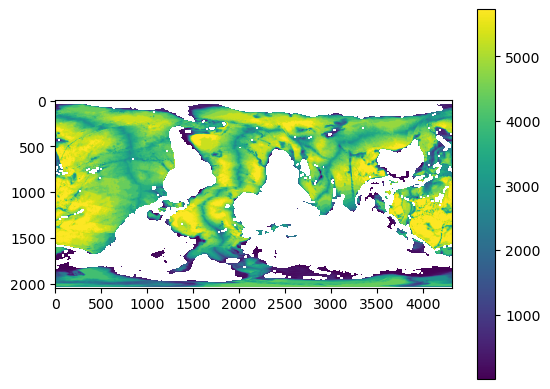

In [122]:
plt.imshow(bathymetry.deptho)
plt.colorbar()

In [124]:
# 1. crop to the mab

mab_hp = reupy.crop_nd(bt_monthly, 'longitude','latitude', mab)


In [158]:
#Get bathymetry in the same region
bathy_match = bathymetry.sel(latitude = slice(np.min(mab_hp.latitude), np.max(mab_hp.latitude)),
                      longitude = slice(np.min(mab_hp.longitude),  np.max(mab_hp.longitude)))

In [155]:
mab_hp_f32 = xr.Dataset(data_vars = {'tob': (['time','latitude','longitude'], mab_hp.sea_water_temperature_at_sea_floor.data)},
                        coords = {'time': mab_hp.time.values,
                                  'latitude': mab_hp.latitude.values.astype('float32'),
                                  'longitude': mab_hp.longitude.values.astype('float32')})

In [159]:
# 2. filter out everything greater than 200m 
mab_hp_200 = mab_hp_f32.where(bathy_match.deptho<200)

In [161]:
# 3. Select for june july august september
def is_jjas(month):
    return (month >= 6) & (month <= 9)

mab_hp_200_jjas = mab_hp_200.sel(time=is_jjas(mab_hp_200['time.month']))

In [217]:
mab_hp.time

<xarray.DataArray 'time' (time: 745)>
array(['1959-01-01T00:00:00.000000000', '1959-02-01T00:00:00.000000000',
       '1959-03-01T00:00:00.000000000', ..., '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 1959-02-01 ... 2021-01-01
Attributes:
    long_name:              time of measurement
    standard_name:          time
    unit:                   1950-1-1
    axis:                   T
    time_origin:            1950-1-1
    comment:                nominal time from the start of the time period
    _CoordinateAxisType:    Time
    ioos_category:          Time
    coverage_content_type:  coordinate

In [290]:
# 4. Create the climatology 1972-2019
def is_base_period(year):
    return (year >= 1972) & (year <= 2019)
    
clim_hp = mab_hp_200_jjas.sel(time = is_base_period(mab_hp_200_jjas['time.year'])).mean('time')

In [291]:
# 5. Remove gridcells that are not part of the climatological cold pool
clim_hp_10 = clim_hp.where(clim_hp.tob <= 10)

In [292]:
# 6. Remove gridcells that are not part of the climatological cold pool
mab_hp_200_jjas_10 = mab_hp_200_jjas.where(clim_hp.tob <=10)

In [293]:
# 7. The final calculation
M_CPIy_hp = (mab_hp_200_jjas_10.groupby('time.year').mean('time') - clim_hp_10).sum(['latitude','longitude'])/len(np.where(np.isnan(clim_hp_10.tob) == False)[0])


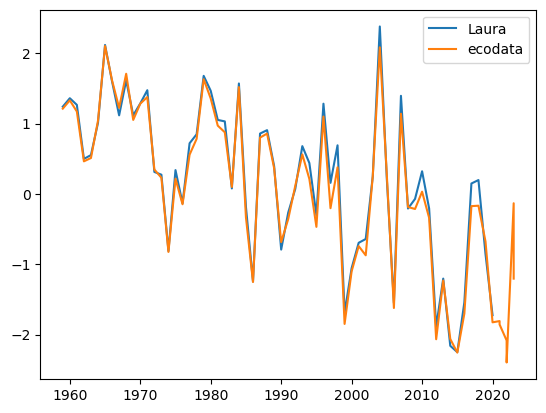

In [294]:
plt.plot(M_CPIy_hp.year, M_CPIy_hp.tob*-1, label = 'Laura')
plt.plot(cp[cp.Var == 'cold_pool_index'].Time, cp[cp.Var == 'cold_pool_index'].Value*-1, label = 'ecodata')
plt.legend()

In [19]:
def Cold_Pool_Index(gridded_bt, lat_name, lon_name):
    mab_m6 = reupy.crop_nd(mom6bt, 'lon', 'lat', mab)
    mab_m6_200 = mab_m6.where(static.deptho < 200).sel(lat = slice(34, 43), lon = slice(282, 292))
    def is_jjas(month):
    return (month >= 6) & (month <= 9)

mab_m6_200_jjas = mab_m6_200.sel(time=is_jjas(mab_m6_200['time.month']))

clim_m6 = mab_m6_200_jjas.mean('time')
clim_10_gl = clim_gl.where(clim_gl.tob <=10)

mab_m6_200_jjas_10 = mab_m6_200_jjas.where(clim_m6.tob <=10)

M_CPIy_m6 = (mab_m6_200_jjas_10.groupby('time.year').mean('time') - clim_10_m6).sum(['lat','lon'])/len(np.where(np.isnan(clim_10_m6.tob) == False)[0])


In [34]:
glbt

<xarray.Dataset>
Dimensions:    (latitude: 217, longitude: 241, time: 342)
Coordinates:
  * latitude   (latitude) float32 30.0 30.08 30.17 30.25 ... 47.83 47.92 48.0
  * longitude  (longitude) float32 -80.0 -79.92 -79.83 ... -60.17 -60.08 -60.0
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2021-06-01
Data variables:
    bottomT    (time, latitude, longitude) float32 ...

In [175]:
cp_r = rdata.read_rda('cold_pool.rda')

C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\rdata\conversion\_conversion.py:856: UserWarning: Missing constructor for R class "tbl_df". The constructor for class "tbl" will be used instead.
  warnings.warn(
C:\Users\Laura.Gruenburg\AppData\Local\anaconda3\envs\mom6_validation_env\Lib\site-packages\rdata\conversion\_conversion.py:856: UserWarning: Missing constructor for R class "tbl". The constructor for class "data.frame" will be used instead.
  warnings.warn(


In [193]:
cp = cp_r['cold_pool']

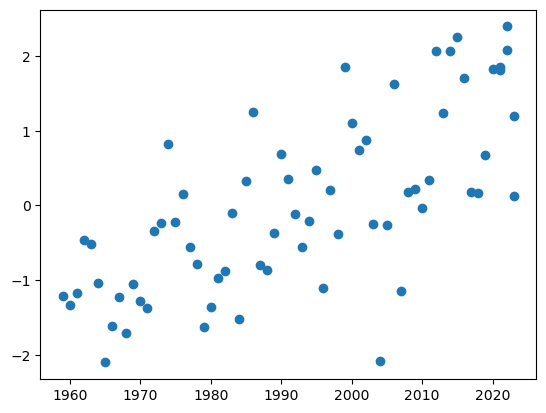

In [214]:
plt.scatter(cp[cp.Var == 'cold_pool_index'].Time, cp[cp.Var == 'cold_pool_index'].Value)

In [212]:
cp.where(cp.Var == 'cold_pool_index'

SyntaxError: incomplete input (79790691.py, line 1)

In [228]:
cp

,source,Time,Var,Value,EPU
1,ROMS,1959,cold_pool_index,-1.212295,MAB
2,ROMS,1959,se_cold_pool_index,0.030909,MAB
3,ROMS,1959,persistence_index,0.338696,MAB
4,ROMS,1959,se_persistence_index,0.024351,MAB
5,ROMS,1959,extent_index,86.191176,MAB
...,...,...,...,...,...
404,PSY,2023,se_cold_pool_index,0.059318,MAB
405,PSY,2023,persistence_index,-0.035448,MAB
406,PSY,2023,se_persistence_index,0.024680,MAB
407,PSY,2023,extent_index,-101.808824,MAB


In [232]:
# 1.  Everything colder than 10C
mab_hp_200_10 = mab_hp_200.where(clim_hp.tob <=10)

In [233]:
# subset to june july august september october

def is_jjaso(month):
    return (month >= 6) & (month <= 10)

mab_hp_200_10_jjaso = mab_hp_200_10.sel(time=is_jjaso(mab_hp_200_10['time.month']))


In [249]:
# 3. if the temperature never gets below 10C in one year that can be nan
years = np.arange(1959,2021)
day_yr = np.empty([len(years),34,82])
day_yr[:,:,:] = np.nan
j=0
for yr in years:
    year_subset = mab_hp_200_10_jjaso.sel(time= mab_hp_200_10_jjaso['time.year'] == yr)
    yr_mo = np.empty([34,82])
    yr_mo[:,:] = np.nan
    for k in np.arange(4,-1,-1):
        yr_mo[np.where(year_subset.tob[k,:,:] > 10)] = k+6
    day_yr[j,:,:] = yr_mo
    j = j+1

In [251]:
# 4. climatology
clim_day_hp = np.nanmean(day_yr, 0)

day_yr_hp = xr.Dataset(data_vars={'month': (['year', 'latitude','longitude'], day_yr)},
           coords = {'year': np.arange(1959,2021),
                     'lat': mab_hp_200_10_jjaso.latitude,
                     'lon': mab_hp_200_10_jjaso.longitude})

day_yr_clim_hp = xr.Dataset(data_vars = {'month': (['latitude','longitude'], clim_day_hp)},
                         coords = {'lat': mab_hp_200_10_jjaso.latitude,
                                   'lon': mab_hp_200_10_jjaso.longitude})

model_piy_hp = ((day_yr_hp - day_yr_clim_hp).sum(['latitude','longitude']))/len(np.where(np.isnan(day_yr_clim_hp.month) == False)[0])

C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_4464\3372926068.py:2: RuntimeWarning: Mean of empty slice
  clim_day_hp = np.nanmean(day_yr, 0)


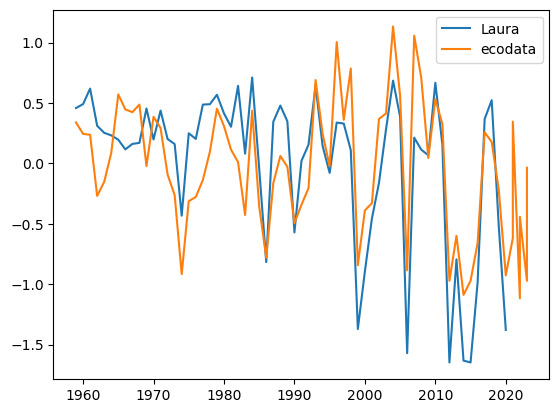

In [252]:
plt.plot(model_piy_hp.year, model_piy_hp.month, label = 'Laura')
plt.plot(cp[cp.Var == 'persistence_index'].Time, cp[cp.Var == 'persistence_index'].Value, label = 'ecodata'),
plt.legend()

In [303]:
def is_jjas(month):
    return (month >= 6) & (month <= 9)

mab_hp_jjas = mab_hp.sel(time=is_jjas(mab_hp['time.month']))

In [262]:
year_subset_hp = mab_hp_200_jjas_10.tob.sel(time= mab_hp_200_jjas_10['time.year'] == 1959).data

In [264]:
year_subset_hp[np.where(year_subset_hp<=10)] = 1

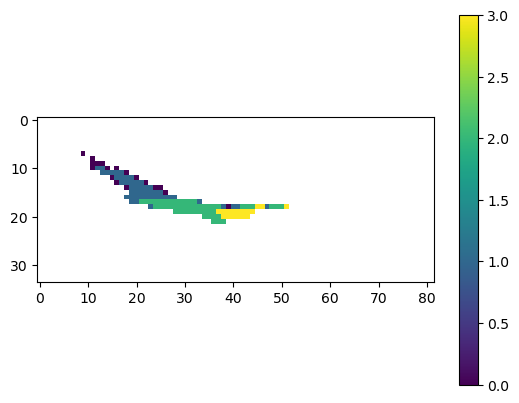

In [299]:
plt.imshow(np.sum(year_subset_hp, axis =0))
plt.colorbar()

In [279]:
np.any(year_subset_diff_hp[:,18,34]>10)

False

In [280]:
k=0
for i in range(34):
    for j in range(82):
        if np.any(year_subset_diff_hp[:,i,j]!=0):
            k =k+1

In [281]:
k

2770

In [282]:
years = np.arange(1959,2021)

sei_hp = [0]
for yr in years:
    year_subset_hp = mab_hp_200_jjas_10.tob.sel(time= mab_hp_200_jjas_10['time.year'] == yr).data
    year_subset_hp[np.where(year_subset_hp<=10)] = 1
    year_subset_hp[np.where(year_subset_hp>10)] = 0
    year_subset_diff_hp = np.diff(year_subset_hp, axis =0)
    k=0
    for i in range(34):
        for j in range(82):
            if np.any(year_subset_diff_hp[:,i,j]!=0):
                k =k+1
    sei_hp = np.append(sei_hp,k)
sei_hp=sei_hp[1:]

In [ ]:
years = np.arange(1959,2021)

sei_hp = [0]
for yr in years:
    year_subset_hp = mab_hp_200_jjas_10.tob.sel(time= mab_hp_200_jjas_10['time.year'] == yr).data
    year_subset_hp[np.where(year_subset_hp<=10)] = 1
    year_subset_hp[np.where(year_subset_hp>10)] = 0
    year_subset_diff_hp = np.diff(year_subset_hp, axis =0)
    sei_n_hp = len(np.where(np.diff(np.where(year_subset_diff_hp == 0)[1])!=0)[0])
    sei_hp = np.append(sei_hp,sei_n_hp)
sei_hp=sei_hp[1:]

In [307]:
years = np.arange(1959,2021)

sei_hp = [0]
for yr in years:
    year_subset_hp = mab_hp_200_jjas.tob.sel(time= mab_hp_200_jjas['time.year'] == yr).data
    year_subset_hp[np.where(year_subset_hp<=10)] = 1
    year_subset_hp[np.where(year_subset_hp>10)] = 0
    year_subset_sum_hp = np.sum(year_subset_hp, axis =0)
    sei_n_hp = len(np.where(year_subset_sum_hp > 1)[0])
    sei_hp = np.append(sei_hp,sei_n_hp)
sei_hp=sei_hp[1:]

In [314]:
years[13:61]

array([1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019])

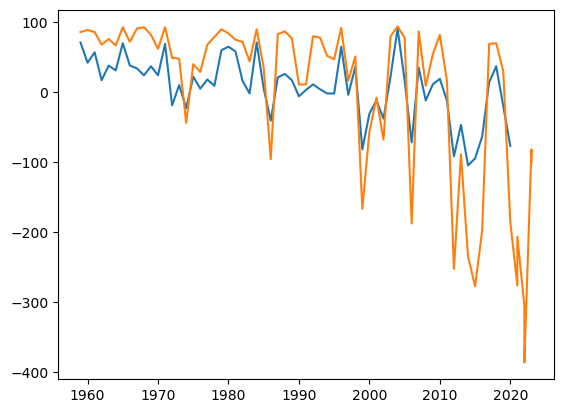

In [315]:
plt.plot(years, sei_hp-np.nanmean(sei_hp[13:61]))
plt.plot(cp[cp.Var == 'extent_index'].Time, cp[cp.Var == 'extent_index'].Value)

In [258]:
cp[cp.Var == 'extent_index']

,source,Time,Var,Value,EPU
5,ROMS,1959,extent_index,86.191176,MAB
11,ROMS,1960,extent_index,89.191176,MAB
17,ROMS,1961,extent_index,86.191176,MAB
23,ROMS,1962,extent_index,68.191176,MAB
29,ROMS,1963,extent_index,76.191176,MAB
...,...,...,...,...,...
383,PSY,2021,extent_index,-206.808824,MAB
389,GLORYS,2022,extent_index,-305.808824,MAB
395,PSY,2022,extent_index,-386.808824,MAB
401,GLORYS,2023,extent_index,-81.808824,MAB
